# Predict interval boundaries on kss audio

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import IPython
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Data Preparation
Create features


## Audio Info

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec


## Character and Syllable Chunk Markers

In [4]:
chunk_dir = 'data/korean-single-speaker/kss_chunks'

chunk_char_df = pd.read_csv(f'{chunk_dir}/chunk_char.csv')
chunk_syl_df = pd.read_csv(f'{chunk_dir}/chunk_syl.csv')


## Event Marker Analysis

### Event Marker Statistics

In [5]:
chunk_char_df['ivl'] = chunk_char_df['stop'] - chunk_char_df['start']
display(chunk_char_df[['ivl', 'start', 'stop']].describe())

# median interval may be used for feature audio length
feat_audio_len_s = chunk_char_df['ivl'].median()
print(f'Feature Audio Length: {feat_audio_len_s}')

,ivl,start,stop
count,133.000000,133.000000,133.000000
mean,0.086957,1.417308,1.504264
std,0.061730,0.998314,1.009050
min,0.006800,0.000000,0.042620
25%,0.044530,0.592430,0.706540
50%,0.073060,1.213770,1.279210
75%,0.113300,2.197060,2.284610
max,0.312600,3.713270,3.972180


Feature Audio Length: 0.07306000000000035


## Event Marker Data

Dictionary of audio_file -> list of event marker times.


In [6]:
char_event_dict = {}
syl_event_dict = {}
audio_files_char = chunk_char_df['audio'].unique()
audio_files_syl = chunk_syl_df['audio'].unique()
audio_files = np.unique(np.concatenate((audio_files_char, audio_files_syl)))

# Warning: The audio file duration is from the 'stop' time of the last event.
# This isn't really guaranteed to be the duration, but it avoids having to load the audio file.
for audio_file in audio_files:
    # Get all start events except for the first one (which is the start of the file)
    char_events = chunk_char_df[chunk_char_df['audio'] == audio_file]['start'].values[1:]
    syl_events = chunk_syl_df[chunk_syl_df['audio'] == audio_file]['start'].values[1:]
    dur = chunk_char_df[chunk_char_df['audio'] == audio_file]['stop'].values[-1]
    char_event_dict[audio_file] = { 'dur': dur, 'events': char_events }
    syl_event_dict[audio_file] = { 'dur': dur, 'events': syl_events }

print(char_event_dict)
print(syl_event_dict)

{'data/korean-single-speaker/kss/1/1_0000.wav': {'dur': 3.52653, 'events': array([0.14298, 0.17326, 0.25143, 0.3011 , 0.39456, 0.49473, 0.52397,
       0.5717 , 0.66385, 0.71846, 0.73074, 0.7928 , 0.86105, 0.8947 ,
       0.94568, 0.98747, 1.00429, 1.05658, 1.12825, 1.20548, 1.24674,
       1.27921, 1.33187, 1.35667, 1.50828, 1.54819, 1.5778 , 1.73609,
       2.04869, 2.15518, 2.28461, 2.3443 , 2.37857, 2.45163, 2.53042,
       2.55297, 2.61609, 2.63233, 2.68239, 2.7029 , 2.76329, 2.86374,
       2.8825 , 2.95272, 3.14772, 3.1583 , 3.4173 ])}, 'data/korean-single-speaker/kss/1/1_0001.wav': {'dur': 3.97218, 'events': array([0.0927 , 0.12765, 0.17218, 0.2192 , 0.2473 , 0.41173, 0.50644,
       0.57461, 0.59243, 0.64042, 0.70654, 0.81835, 0.83326, 0.95153,
       1.09444, 1.11834, 1.20856, 1.37623, 1.59665, 1.64288, 1.76991,
       1.89271, 1.99178, 2.06911, 2.15357, 2.19706, 2.26984, 2.40939,
       2.50919, 2.78858, 2.85241, 2.89864, 2.99798, 3.0465 , 3.09567,
       3.16021, 3.20729, 3

## Audio Data

* Create timestamps with equivalent intervals and "cover" the full audio file with those intervals
 (later the audio file will be padded as needed)
* Find the event closest to the midpoint of those intervals
  * if there is no event, that interval's event value is NaN
  * else event value = (midpoint - event)

DF

i_start, i_stop, i_midpoint, event_offset, audio_dur, audio

In [20]:
window_size_s = 0.5
window_stride_s = 0.025

In [21]:
def find_nearest_event(t, event_list):
    event_dists = abs(event_list - t)
    nearest_event_idx = np.argmin(event_dists)
    return event_list[nearest_event_idx]

def a_round(val):
    return round(val, 6) if isinstance(val, float) else val

def create_audio_df(event_dict, filenames):
    df_dict = {
        'i_start': [],
        'i_stop': [],
        'i_midpoint': [],
        'nearest_event': [],
        'audio_dur': [],
        'audio': []
    }
    for fn in filenames:
        dur = event_dict[fn]['dur']
        ptr = 0.0

        while ptr < dur:
            w_start = ptr
            w_stop = ptr + window_size_s
            w_midpoint = w_start + (w_stop - w_start)/2

            nearest = find_nearest_event(w_midpoint, event_dict[audio_file]['events'])
            # offset = nearest - w_midpoint
            # offset_is_in_window = abs(offset) > window_size_s / 2
            # event_offset_val = offset if offset_is_in_window  else None

            df_dict['i_start'].append(a_round(w_start))
            df_dict['i_stop'].append(a_round(w_stop))
            df_dict['i_midpoint'].append(a_round(w_midpoint))
            df_dict['nearest_event'].append(a_round(nearest))
            # df_dict['event_offset'].append(a_round(event_offset_val))
            df_dict['audio_dur'].append(dur)
            df_dict['audio'].append(fn)

            ptr = a_round(ptr + window_stride_s)

    audio_df = pd.DataFrame.from_dict(df_dict)
    audio_df['evt_dist'] = audio_df['nearest_event'] - audio_df['i_midpoint']
    audio_df['valid_event'] = audio_df['evt_dist'].abs() < (window_size_s / 2)
    return audio_df

audio_char_df = create_audio_df(char_event_dict, audio_files)
print(audio_char_df['valid_event'].value_counts())
display(audio_char_df)
print('----')
audio_syl_df = create_audio_df(syl_event_dict, audio_files)
print(audio_syl_df['valid_event'].value_counts())
display(audio_syl_df)

True     335
False    130
Name: valid_event, dtype: int64
----
True     335
False    130
Name: valid_event, dtype: int64


,i_start,i_stop,i_midpoint,nearest_event,audio_dur,audio,evt_dist,valid_event
0,0.000,0.500,0.250,0.20956,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,-0.04044,True
1,0.025,0.525,0.275,0.30481,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.02981,True
2,0.050,0.550,0.300,0.30481,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.00481,True
3,0.075,0.575,0.325,0.30481,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,-0.02019,True
4,0.100,0.600,0.350,0.30481,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,-0.04519,True
...,...,...,...,...,...,...,...,...
460,2.200,2.700,2.450,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.25210,False
461,2.225,2.725,2.475,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.27710,False
462,2.250,2.750,2.500,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.30210,False
463,2.275,2.775,2.525,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.32710,False


,i_start,i_stop,i_midpoint,nearest_event,audio_dur,audio,evt_dist,valid_event
0,0.000,0.500,0.250,0.15231,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,-0.09769,True
1,0.025,0.525,0.275,0.15231,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,-0.12269,True
2,0.050,0.550,0.300,0.15231,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,-0.14769,True
3,0.075,0.575,0.325,0.48924,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.16424,True
4,0.100,0.600,0.350,0.48924,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.13924,True
...,...,...,...,...,...,...,...,...
460,2.200,2.700,2.450,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.25210,False
461,2.225,2.725,2.475,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.27710,False
462,2.250,2.750,2.500,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.30210,False
463,2.275,2.775,2.525,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.32710,False


## Feature Prep

X is slices of audio with window_size_s duration

y is valid_event boolean

TODO: Normalize the data across audio files


In [66]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
import math



audio_dict = {}

for fn in audio_files:
    wav, sr = librosa.load(fn)
    audio_dict[fn] = {'sr': sr, 'wav': wav}

# print(audio_dict['data/korean-single-speaker/kss/1/1_0000.wav'])
# print(audio_dict['data/korean-single-speaker/kss/1/1_0003.wav'])

class AudioPrep:

    def __init__(self, wav, sr, pad_s=(0,0)):
        self.sr = sr
        self.pad_samps = tuple(map(self.t_to_samps, pad_s))

        self.wav = np.pad(wav, self.pad_samps, 'edge')

    def t_to_samps(self, t):
        return int(math.ceil(t * self.sr))

    # ivls is numpy array of  [start, stop] timestamps
    def slice_by_time(self, ivls):
        idxs = (ivls * self.sr).astype(int)
        return np.asarray([self.wav[rs[0]:rs[1]] for rs in idxs])

    def mfcc_slice(self, ivls):
        sliced_wavs = self.slice_by_time(ivls)
        hop_length = 128
        n_mfcc = 12

        # n_mfcc might be useful as a hyper parameter
        mfccs = [librosa.feature.mfcc(y=w, sr=self.sr, n_mfcc=n_mfcc, hop_length=hop_length) for w in sliced_wavs]
        return mfccs


def get_ivls_np(audio_df, f):
    return audio_df[audio_df['audio'] == f][['i_start', 'i_stop']].values


def get_X(audio_wav_dict, audio_df, f):
    ap = AudioPrep(audio_wav_dict[f]['wav'], audio_wav_dict[f]['sr'], (0,window_size_s))
    ivs = get_ivls_np(audio_df, f)
    return ap.mfcc_slice(ivs)

nested_x = [get_X(audio_dict, audio_char_df, fn) for fn in audio_files]
    # ap = AudioPrep(audio_dict[fn]['wav'], audio_dict[fn]['sr'])
    # ivls = get_ivls_np(audio_syl_df, fn)
    # x = ap.slice_by_time(ivls)
    # get_X(audio_dict, audio_syl_df, fn)
    # print(x.shape)

x_a = [val for x_partial in nested_x for val in x_partial]
x_shapes = np.asarray([x_.shape for x_ in x_a ])
print((np.min(x_shapes), np.max(x_shapes)))

X = pad_sequences(x_a, padding='post')
print(f'X shape: {X.shape}')

y = audio_char_df['valid_event'].values.astype(float)
print (f'y shape: {y.shape}')

X, y = shuffle(X, y, random_state=42)

X.resize(X.shape[0], X.shape[1], X.shape[2], 1)
print(f'X shape, shuffled: {X.shape}')
print (f'y shape, shuffled: {y.shape}')

X_train = X[:400]
y_train = y[:400]

X_test = X[401:]
y_test = y[401:]

print(f'X_train shape: {X_train.shape}')
print (f'y_train shape: {y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print (f'y_test shape: {y_test.shape}')


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(12, 87)
X shape: (465, 12, 87)
y shape: (465,)
X shape, shuffled: (465, 12, 87, 1)
y shape, shuffled: (465,)
X_train shape: (400, 12, 87, 1)
y_train shape: (400,)
X_test shape: (64, 12, 87, 1)
y_test shape: (64,)


In [67]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

kernel_size = (3,3)
input_shape = (X.shape[1], X.shape[2], 1)
print(f'kernel size: {kernel_size}')
print(f'input_shape: {input_shape}')

model = Sequential()
# model.add(layers.Embedding(X.shape[0], kernel_size, input_shape=X.shape[1]))
model.add(layers.Conv2D(32, kernel_size, input_shape=input_shape, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128))
# model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=31,
                    validation_split=0.2)

kernel size: (3, 3)
input_shape: (12, 87, 1)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 10, 85, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 42, 32)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 3, 40, 64)         18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 20, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_13 

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


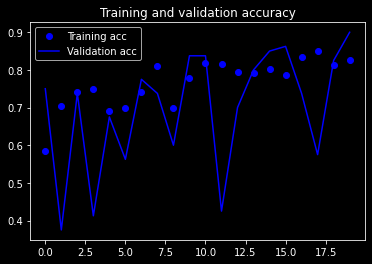

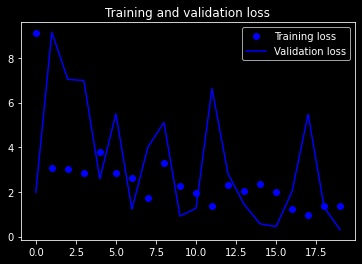

In [68]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [78]:

y_pred = model.predict_classes(X_test)

print(f'y_test shape: {y_pred.shape}')

tmp_df = audio_syl_df[['valid_event']][401:]
tmp_df['pred'] = y_pred.astype(bool)
# tmp_df[tmp_df['valid_event'] != tmp_df['pred']]
tmp_df['correct'] = tmp_df['valid_event'] == tmp_df['pred']
tmp_df['correct'].describe()

y_test shape: (64, 1)


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


count       64
unique       2
top       True
freq        46
Name: correct, dtype: object

In [69]:
data_dir = 'data/korean-single-speaker/kss'


In [63]:



data_files = chunk_char_df['audio'].unique()
sr_ = None
audio_ = None
for wv in data_files:
    fn = f'{wv}'
    print(f'Data file to analyze: {fn}')
    print(f'current sample rate: {sr_}')
    new_audio_, new_sr_ = librosa.load(fn)
    print(f"latest sample rate: {new_sr_}")
    print(f'new_audio_ shape: {new_audio_.shape}')
    if sr_ is None:
        sr_ = new_sr_
    else:
        assert(new_sr_ == sr_)

    if audio_ is None:
        audio_ = new_audio_
    else:
        audio_ = np.concatenate((audio_, new_audio_))
    print('new audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(new_audio_), np.max(new_audio_)))
    print('full audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(audio_), np.max(audio_)))





ap = AudioPrep(sr_, 0.75)
print(ap.size)
_b = ap.resize(audio_)

print(_b.shape)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,4), tight_layout=True)
fig.suptitle('Waveforms', fontsize=16)
ax1.set_title(f'librosa ({sr_})')
ax1.plot(audio_)

Data file to analyze: data/korean-single-speaker/kss/1/1_0000.wav
current sample rate: None
latest sample rate: 22050
new_audio_ shape: (77760,)
new audio file min~max range: -0.98 to -0.98
full audio file min~max range: -0.98 to -0.98
Data file to analyze: data/korean-single-speaker/kss/1/1_0001.wav
current sample rate: 22050
latest sample rate: 22050
new_audio_ shape: (87587,)
new audio file min~max range: -0.65 to -0.65
full audio file min~max range: -0.98 to -0.98
Data file to analyze: data/korean-single-speaker/kss/1/1_0002.wav
current sample rate: 22050
latest sample rate: 22050
new_audio_ shape: (38787,)
new audio file min~max range: -0.61 to -0.61
full audio file min~max range: -0.98 to -0.98
Data file to analyze: data/korean-single-speaker/kss/1/1_0003.wav
current sample rate: 22050
latest sample rate: 22050
new_audio_ shape: (50881,)
new audio file min~max range: -0.46 to -0.46
full audio file min~max range: -0.98 to -0.98


AttributeError: 'AudioPrep' object has no attribute 'size'

## Event Marker (Boundaries) Dataset
# audio | event_idx



In [27]:
# boundary_audio
# boundary_idx | audio_data

# boundary_mfcc
# boundry_idx | mfcc_data


    syl    start     stop                                        audio
0     0  0.00000  0.08071  data/korean-single-speaker/kss/1/1_0003.wav
1    그  0.08071  0.15231  data/korean-single-speaker/kss/1/1_0003.wav
2   는  0.15231  0.48924  data/korean-single-speaker/kss/1/1_0003.wav
3     0  0.48924  0.75129  data/korean-single-speaker/kss/1/1_0003.wav
4    아  0.75129  0.88808  data/korean-single-speaker/kss/1/1_0003.wav
5    내  0.88808  1.02123  data/korean-single-speaker/kss/1/1_0003.wav
6   를  1.02123  1.23614  data/korean-single-speaker/kss/1/1_0003.wav
7   많  1.23614  1.45550  data/korean-single-speaker/kss/1/1_0003.wav
8    이  1.45550  1.53270  data/korean-single-speaker/kss/1/1_0003.wav
9    아  1.53270  1.75352  data/korean-single-speaker/kss/1/1_0003.wav
10  낀  1.75352  1.97293  data/korean-single-speaker/kss/1/1_0003.wav
11   다  1.97293  2.19790  data/korean-single-speaker/kss/1/1_0003.wav
12    0  2.19790  2.30753  data/korean-single-speaker/kss/1/1_0003.wav
